In [1]:
# Import necessary modules:
from astropy.io import fits

import h5py
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import copy
import pickle
import os
import gc

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K


2025-10-21 16:15:39.454354: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-21 16:15:39.454444: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-21 16:15:39.637774: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-21 16:15:39.935017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:

# ------------------------------------------------------------------------------------------------------------

# Flag to remove the young and old clusters:
flag_remove_extremes = False # Currently removing younger than 10^7 years and older than 10^9.5

# Flag to augment or not:
flag_use_augmented = False

# If we are blacking out:
flag_black = False

# Choose the normalization method:
norm_by = "five-images"  # "dataset", "filter, "five-images", single-image"
# normalizing by dataset or by filter makes the weird results because the points values are too different. 
# very small or very large.

# ------------------------------------------------------------------------------------------------------------
# Directories:

# Raw data:
dir_data_raw = "/orcd/pool/005/vianajr/cluster_ages_1/data/data_raw/raw_phangs_dataset.h5"

# Aux text:
txt_extremes = "yes" if flag_remove_extremes else "no"
txt_augment = "yes" if flag_use_augmented else "no"
# Base prefix for the results directory:
results_prefix = f"single_case_5im_remextremes_{txt_extremes}_augment_{txt_augment}_"

# If we do have blackout:
if flag_black:
    
    # Flag to use the inner or outer region of the circle:
    flag_black_inner = False # If flag_black_inner is True, we are blacking out the center, if Flase black out outer.
    # Define the radius for the blacking:
    R = 6

    # If inner:
    if flag_black_inner: 
        
        # Extension for the paths:
        extension = "inner"
        
    # If outer: 
    else: 
        # Extension for the paths:
        extension = "outer"

    

# ------------------------------------------------------------------------------------------------------------

# Number of models per case to get an average of errors:
num_models_per_case = 5

# Flag to plot preliminary data visualization:
flag_plot_data_viz = True

# ------------------------------------------------------------------------------------------------------------
# Display:

print()
print()
print("--------------------------------------")
print("SINGLE -------------------------------")
print("5-im case ----------------------------")
print()
print("Params:")
print()
print("flag_remove_extremes: ", flag_remove_extremes)
print("flag_use_augmented: ", flag_use_augmented)
print()
print("flag_black: ", flag_black)
if flag_black:
    print()
    print("flag_black_inner: ", flag_black_inner)
    print("R: ", R)
print()
print("Normalization by")
print(norm_by)
print()





--------------------------------------
SINGLE -------------------------------
5-im case ----------------------------

Params:

flag_remove_extremes:  False
flag_use_augmented:  False

flag_black:  False

Normalization by
five-images



In [6]:

# ------------------------------------------------------------------------------------------------------------
# Set the seed for reproducibility
random_seed = 15
random.seed(random_seed)
np.random.seed(random_seed)  # If you also want to ensure reproducibility with numpy functions

# ------------------------------------------------------------------------------------------------------------
# Class to read the dataset in the format it is:
class ReadPhangsH5:
    
    def __init__(self, hdf5_filename):
        # loading from hdf5 file
        with h5py.File(hdf5_filename, "r") as hf:
            
            # Get the cluster ID:
            self.cluster_ids = np.array(hf["cluster_ids"], dtype=np.int32)
            # Use astype(str) to correctly convert HDF5 string datasets to Python strings, for the galaxy_ids:
            self.galaxy_ids = np.array(hf["galaxy_ids"]).astype(str)
            # Get the image cutouts:
            self.image_cutouts = np.array(hf["image_cutouts"], dtype=np.float32)
            # Get the log of the ages:
            self.cluster_log_ages = np.array(hf["cluster_log_ages"], dtype=np.float32)

    def __getitem__(self, index):
        # Get the image cutouts for the instance (5 images)
        x = self.image_cutouts[index]

        # Get the log of the ages:
        y = self.cluster_log_ages[index]

        return x, y

    def __len__(self):
        return len(self.image_cutouts)

    
# ------------------------------------------------------------------------------------------------------------
# Function to split the input (X) and output (Y) from the dataset
def separate_X_Y(dataset):
    X = [x for x, _ in dataset]
    Y = [y for _, y in dataset]
    return np.array(X), np.array(Y)


# ------------------------------------------------------------------------------------------------------------
# Function to blackout a circle from the center:
def blackout(images, R, flag_black_inner):
    """
    Apply a circular mask blackout to the center of the images with radius R.
    The blackout will be an approximation since the images are 2D matrices.
    
    :param images: A numpy array of shape (n_samples, 5, 112, 112)
    :param R: Radius of the blackout circle (better if it is an odd number)
    :param flag_black_inner: If True we are removing the Inner center of the image, else the outer.
    :return: Modified images with the center blacked out
    """
    # Dimensions of the images
    n_samples, filters, height, width = images.shape # Here shape is: samples, filters, height, widht
    
    # Center of the images
    center_x, center_y = width // 2, height // 2  # For 111x111, this will be 55, 55
    
    # Create a mask with the same dimensions as the image
    y, x = np.ogrid[:height, :width]
    
    # Correct the radius to be applied in a "circle" like pattern
    mask = (x - center_x) ** 2 + (y - center_y) ** 2 <= (R ** 2)
    
    # If we are not blacking out the inner, then we are the outer:
    if not flag_black_inner:
        mask = np.logical_not(mask)
        
    # Show the mask:
    # plt.imshow(mask)

    # Apply the mask to each image in the dataset
    for i in range(n_samples):
        for j in range(filters):
            images[i, j][mask] = 0  # Zero out the masked area
        
    return images


# ------------------------------------------------------------------------------------------------------------
# Define a function to split the data into tr, vl, and ts sets
def split_dataset(N, tr_ratio=0.7, vl_ratio=0.15, seed=42):
    
    # Initialize:
    random.seed(seed)
    indices = list(range(N))
    random.shuffle(indices)
    
    tr_split = int(tr_ratio * N)
    vl_split = int((tr_ratio + vl_ratio) * N)
    
    tr_indices = indices[:tr_split]
    vl_indices = indices[tr_split:vl_split]
    ts_indices = indices[vl_split:]
    
    return tr_indices, vl_indices, ts_indices


    
    
# ------------------------------------------------------------------------------------------------------------
# Function to augment a dataset by creating 8 versions 4 rotations and reversed 4 totations:
def augment_dataset_full(data):
    
    # The actual augmented data:
    aug_data = []
    # Reference for the past indexes that they corresponded to:
    aug_past_idxs = [] 
    
    for i, (x, y) in enumerate(data):

        # Original + 90° rotations
        for i in range(4):
            
            # Rotate 0°, 90°, 180°, 270°
            rot_x = np.array([ np.rot90(image, k=i) for image in x ])
            
            # Increase data:
            aug_data.append( (rot_x, y) )  
            aug_past_idxs.append(i)
        
        # Flip the image (up-down flip)
        flip_x = np.array([ np.flipud(image) for image in x ])
        
        # Flipped + 90° rotations
        for i in range(4):
            # Rotate flipped image
            rot_flip_x = np.array([ np.rot90(flip_image, k=i) for flip_image in flip_x ])
            # Increase data:
            aug_data.append( (rot_flip_x, y) )  
            aug_past_idxs.append(i)


    return aug_data, aug_past_idxs



In [7]:
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------
# ------------------------------------------------------------------------------------------------------------

# Start running the code

# Create an instance of the dataset class
raw_dataset = ReadPhangsH5(dir_data_raw)

# Get X and Y:
raw_X, raw_Y = separate_X_Y(raw_dataset)
# Display:
print("X.shape: ", raw_X.shape)
print()

# Get the list of cluster ids and galaxy ids:
raw_clust_ids = raw_dataset.cluster_ids
raw_galax_ids = raw_dataset.galaxy_ids


X.shape:  (8651, 5, 112, 112)



In [8]:
raw_X.shape

(8651, 5, 112, 112)

In [ ]:
cur_X[0]

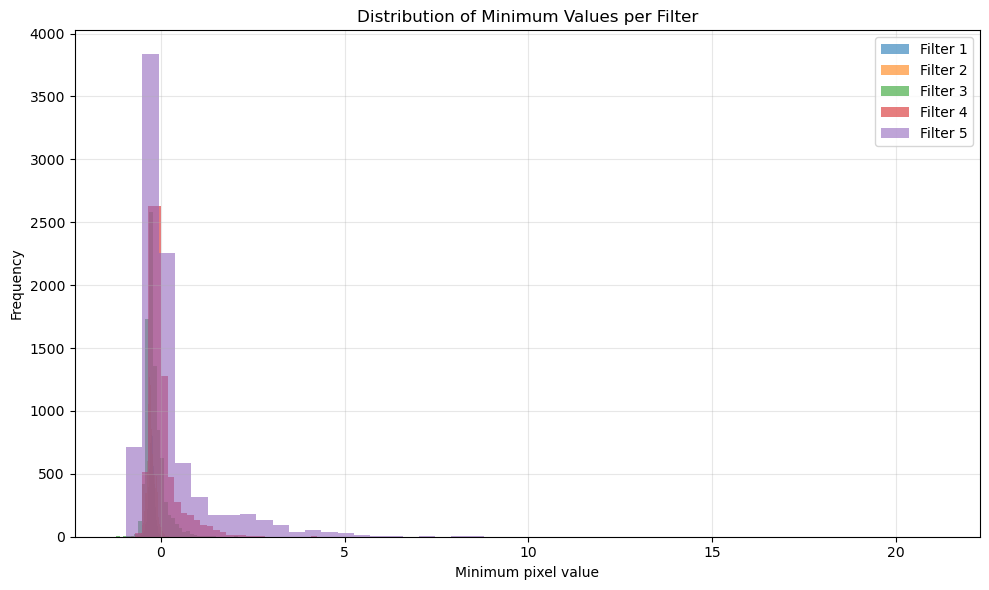

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# raw_X: shape (8651, 5, 112, 112)
# Step 1: compute per-instance, per-channel minima
min_values = np.min(raw_X, axis=(2, 3))  # shape (8651, 5)

# Step 2: plot histograms, one per channel
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for ch in range(5):
    plt.hist(min_values[:, ch], bins=50, color=colors[ch], alpha=0.6, label=f'Filter {ch+1}')

plt.title('Distribution of Minimum Values per Filter')
plt.xlabel('Minimum pixel value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [ ]:
# Step 2: plot histograms, one per channel
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for ch in range(5):
    plt.hist(min_values[:, ch], bins=100, color=colors[ch], alpha=0.6, label=f'Filter {ch+1}')

plt.title('Distribution of Minimum Values per Filter')
plt.xlabel('Minimum pixel value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [11]:
min_values

array([[-0.28048623, -0.1681978 , -0.08352381, -0.08876728, -0.13069312],
       [-0.18942738, -0.13982216, -0.07384261, -0.08359715, -0.10469635],
       [-0.34926817, -0.18330906, -0.06991687, -0.11934541, -0.11877149],
       ...,
       [-0.2956931 , -0.31610298, -0.278814  , -0.25443855, -0.29442737],
       [-0.24462377, -0.24883963, -0.25724128, -0.28624928, -0.41948313],
       [-0.34860095, -0.26001018, -0.29897985, -0.24948636, -0.33740404]],
      dtype=float32)

In [12]:
max_values = np.max(raw_X, axis=(2, 3))  # shape (8651, 5)

In [13]:
max_values

array([[236.75467   ,  24.162054  ,   6.69666   ,   6.2715693 ,
          6.5495315 ],
       [  1.790209  ,   1.6526753 ,   2.907355  ,   4.3654313 ,
          7.264048  ],
       [ 44.9289    ,  75.561844  ,   0.80544996,   1.3348206 ,
          2.4638278 ],
       ...,
       [  0.38050163,   0.34390998,   1.3935574 ,   1.6324856 ,
          8.993849  ],
       [  1.3195616 ,   1.1254162 ,   0.87044954,   0.72220975,
          0.97710836],
       [  0.68681765,   0.7554263 ,   4.4913807 ,  12.340277  ,
         35.63164   ]], dtype=float32)

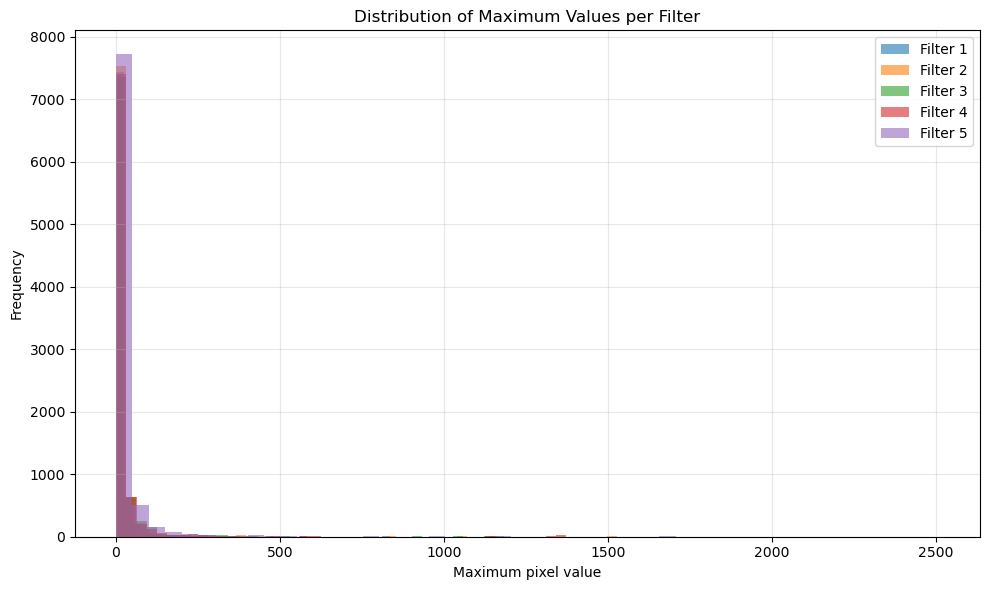

In [14]:
# Step 2: plot histograms, one per channel
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for ch in range(5):
    plt.hist(max_values[:, ch], bins=50, color=colors[ch], alpha=0.6, label=f'Filter {ch+1}')

plt.title('Distribution of Maximum Values per Filter')
plt.xlabel('Maximum pixel value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# raw_X: shape (8651, 5, 112, 112)
# Step 1: compute per-instance, per-channel minima
min_values = np.min(raw_X, axis=(2, 3))  # shape (8651, 5)

# Step 2: plot histograms, one per channel
plt.figure(figsize=(10, 6))
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple']

for ch in range(5):
    plt.hist(min_values[:, ch], bins=50, color=colors[ch], alpha=0.6, label=f'Filter {ch+1}')

plt.title('Distribution of Minimum Values per Filter')
plt.xlabel('Minimum pixel value')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
